In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In /Users/lacemaker/anaconda3/envs/data_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/lacemaker/anaconda3/envs/data_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/lacemaker/anaconda3/envs/data_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/lacemaker/anaconda3/envs/data_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor rele

Here we start with simple cross-validation, no balancing (later will add balancing)

In [2]:
datadir = "../data"
savedir = "../saves/catboost"
if not os.path.exists(savedir):
    os.makedirs(savedir)
os.listdir(datadir)
df_train = pd.read_csv(os.path.join(datadir, "single_muts_train.csv"))
df_test = pd.read_csv(os.path.join(datadir, "single_muts_test.csv"))

df_train['topology'] = df_train.name.apply(lambda x: x.split("_")[0])
df_test['topology'] = df_test.name.apply(lambda x: x.split("_")[0])

df_train['name'] = df_train.name.apply(lambda x: x.split(".")[0])
df_test['name'] = df_test.name.apply(lambda x: x.split(".")[0])


# 1. Start with sequence-based prediction

In [3]:
sorted(set([x for xs in df_test.sequence for x in xs]))
#df_train[['sequence', "stabilityscore"]].values


['A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [4]:
aa = """Alanine	Ala	A
Arginine	Arg	R
Asparagine	Asn	N
Aspartic Acid	Asp	D
Cysteine	Cys	C
Glutamic Acid	Glu	E
Glutamine	Gln	Q
Glycine	Gly	G
Histidine	His	H
Isoleucine	Ile	I
Leucine	Leu	L
Lysine	Lys	K
Methionine	Met	M
Phenylalanine	Phe	F
Proline	Pro	P
Serine	Ser	S
Threonine	Thr	T
Tryptophan	Trp	W
Tyrosine	Tyr	Y
Valine	Val	V"""

aadict = dict()
for line in aa.split("\n"):
    data = line.split()
    if len(data)< 3:
        continue
    name = " ".join(data[0:-2])
    l3, l1 = data[-2:]
    aadict[l1] = (name, l3)
aa = sorted(aadict)
aa2idx = {x: i for i, x in enumerate(aa)}

In [5]:
x_full_train = np.stack(df_train.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
y_full_train = df_train.stabilityscore.values

x_full_test = np.stack(df_test.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
y_full_test = df_test.stabilityscore.values

In [6]:
#x_full_train = np.stack(df_train.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
topologies = sorted(df_train.topology.drop_duplicates().values)
top2idx = {x: i for i, x in enumerate(topologies)}
names = sorted(df_train.name.drop_duplicates().values)
name2idx = {x: i for i, x in enumerate(names)}
# df_test[~df_test.name.isin(names)]

topologies_train = df_train.topology.apply(lambda x: top2idx[x]).values
names_train = df_train.name.apply(lambda x: name2idx[x]).values

topologies_test = df_test.topology.apply(lambda x: top2idx[x]).values
names_test = df_test.name.apply(lambda x: name2idx[x]).values

In [7]:
NFOLDS = 5
RANDOM_SEED = 42

SAVE_PREFIX = os.path.join(savedir, "catboost_kf_")
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor


In [34]:
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
cat_features=np.arange(x_full_train.shape[1])
NITERATIONS=1000

split_data = dict()
for fold, (train_index, test_index) in enumerate(kf.split(x_full_train)):
    split_data[fold] = (train_index, test_index)
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]
    # next model-specific
    model = CatBoostRegressor(iterations=NITERATIONS, depth=7, learning_rate=1, loss_function='RMSE',
                              metric_period=NITERATIONS//10, random_seed=RANDOM_SEED)
    #train the model
    model.fit(x_train, y_train, eval_set=(x_val, y_val))
    # make the prediction using the resulting model
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)
    # break


0:	learn: 0.2555933	test: 0.2603159	best: 0.2603159 (0)	total: 11ms	remaining: 11s
100:	learn: 0.1528499	test: 0.2105727	best: 0.2105727 (100)	total: 1.02s	remaining: 9.13s
200:	learn: 0.1236841	test: 0.2089494	best: 0.2089494 (200)	total: 2.3s	remaining: 9.15s
300:	learn: 0.1044154	test: 0.2070838	best: 0.2070838 (300)	total: 3.35s	remaining: 7.78s
400:	learn: 0.0887187	test: 0.2071372	best: 0.2070838 (300)	total: 4.63s	remaining: 6.92s
500:	learn: 0.0772611	test: 0.2074262	best: 0.2070838 (300)	total: 5.94s	remaining: 5.92s
600:	learn: 0.0679794	test: 0.2075318	best: 0.2070838 (300)	total: 6.97s	remaining: 4.63s
700:	learn: 0.0607151	test: 0.2078638	best: 0.2070838 (300)	total: 7.95s	remaining: 3.39s
800:	learn: 0.0543425	test: 0.2081236	best: 0.2070838 (300)	total: 8.93s	remaining: 2.22s
900:	learn: 0.0490889	test: 0.2084471	best: 0.2070838 (300)	total: 9.82s	remaining: 1.08s
999:	learn: 0.0446643	test: 0.2092707	best: 0.2070838 (300)	total: 10.8s	remaining: 0us

bestTest = 0.207083

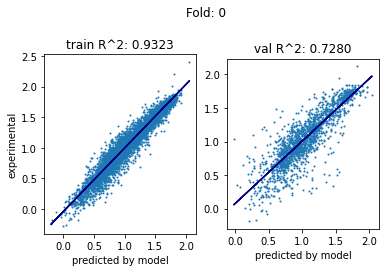

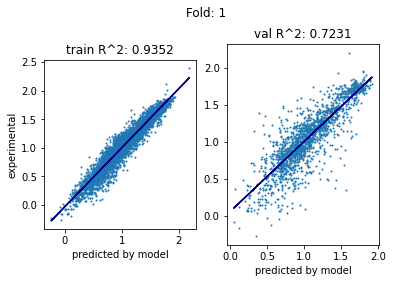

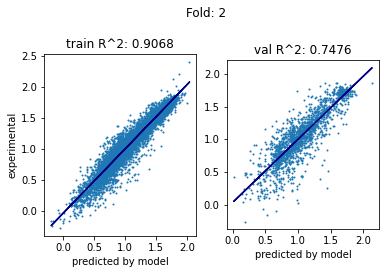

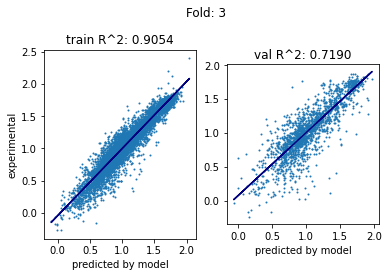

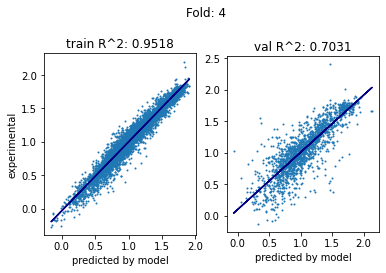

Train (using mean prediction) R^2= 0.915783814170276
Train (using median prediction) R^2= 0.9269493449914614
Test (using mean prediction) R^2= 0.7551295784950929
Test (using median prediction) R^2= 0.7487997733761282


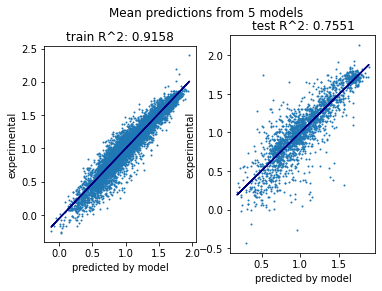

In [35]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");

In [37]:
# in normal production setting cv is used just to search for model parameters,
# after that the model is trained on the whole train dataset.
# Let's compare our best model R^2 on test with the best ensemble.
# it won't be better than ensemble in the terms of performance, but it will run on new data faster.
model_all_data = CatBoostRegressor(
    iterations=NITERATIONS, depth=7, learning_rate=1, loss_function='RMSE',
    metric_period=NITERATIONS//10
)
model_all_data.fit(x_full_train, y_full_train, eval_set=(x_full_train, y_full_train))
path = f"{SAVE_PREFIX}all.cbm"
model_all_data.save_model(path)
predictions = model_all_data.predict(x_full_test)
score=r2_score(y_full_test, predictions)
print("R^2 score on test set:", score)

0:	learn: 0.2557684	test: 0.2557684	best: 0.2557684 (0)	total: 18.2ms	remaining: 18.2s
100:	learn: 0.1557981	test: 0.1557981	best: 0.1557981 (100)	total: 1.08s	remaining: 9.67s
200:	learn: 0.1274552	test: 0.1274552	best: 0.1274552 (200)	total: 2.58s	remaining: 10.3s
300:	learn: 0.1076370	test: 0.1076370	best: 0.1076370 (300)	total: 3.54s	remaining: 8.22s
400:	learn: 0.0942750	test: 0.0942750	best: 0.0942750 (400)	total: 4.57s	remaining: 6.83s
500:	learn: 0.0828967	test: 0.0828967	best: 0.0828967 (500)	total: 5.57s	remaining: 5.54s
600:	learn: 0.0739197	test: 0.0739197	best: 0.0739197 (600)	total: 6.53s	remaining: 4.34s
700:	learn: 0.0671281	test: 0.0671281	best: 0.0671281 (700)	total: 7.61s	remaining: 3.25s
800:	learn: 0.0608179	test: 0.0608179	best: 0.0608179 (800)	total: 9.12s	remaining: 2.27s
900:	learn: 0.0549031	test: 0.0549031	best: 0.0549031 (900)	total: 10.3s	remaining: 1.14s
999:	learn: 0.0502040	test: 0.0502040	best: 0.0502040 (999)	total: 11.5s	remaining: 0us

bestTest = 0.0

## StratifiedKFold


In [38]:
SAVE_PREFIX = os.path.join(savedir, "catboost_skf_")
NFOLDS=5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
cat_features=np.arange(x_full_train.shape[1])
NITERATIONS=1500

split_data = dict()
for fold, (train_index, test_index) in enumerate(skf.split(x_full_train, topologies_train)):
    split_data[fold] = (train_index, test_index)
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]
    # next model-specific
    model = CatBoostRegressor(iterations=NITERATIONS, depth=5, learning_rate=1, loss_function='RMSE',
                              metric_period=NITERATIONS//10, random_seed=RANDOM_SEED)
    #train the model
    model.fit(x_train, y_train, eval_set=(x_val, y_val))
    # make the prediction using the resulting model
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)
    # break


0:	learn: 0.2626422	test: 0.2561546	best: 0.2561546 (0)	total: 37.4ms	remaining: 56.1s
150:	learn: 0.1585766	test: 0.2109779	best: 0.2109779 (150)	total: 1.47s	remaining: 13.1s
300:	learn: 0.1303871	test: 0.2098433	best: 0.2098433 (300)	total: 2.43s	remaining: 9.69s
450:	learn: 0.1117762	test: 0.2105028	best: 0.2098433 (300)	total: 3.39s	remaining: 7.89s
600:	learn: 0.0993447	test: 0.2124136	best: 0.2098433 (300)	total: 4.3s	remaining: 6.43s
750:	learn: 0.0897207	test: 0.2134655	best: 0.2098433 (300)	total: 5.8s	remaining: 5.78s
900:	learn: 0.0819113	test: 0.2130227	best: 0.2098433 (300)	total: 6.89s	remaining: 4.58s
1050:	learn: 0.0753479	test: 0.2139692	best: 0.2098433 (300)	total: 7.9s	remaining: 3.38s
1200:	learn: 0.0687091	test: 0.2144748	best: 0.2098433 (300)	total: 8.98s	remaining: 2.24s
1350:	learn: 0.0632456	test: 0.2146738	best: 0.2098433 (300)	total: 10.5s	remaining: 1.16s
1499:	learn: 0.0588742	test: 0.2137873	best: 0.2098433 (300)	total: 13.2s	remaining: 0us

bestTest = 0.

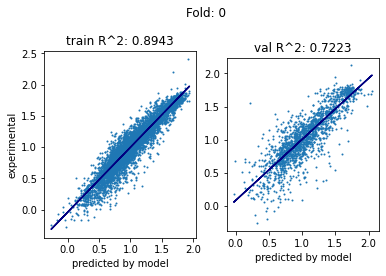

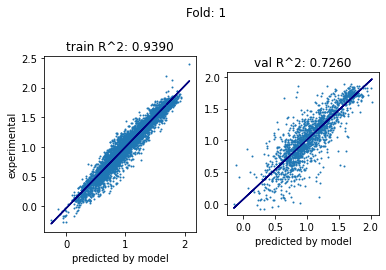

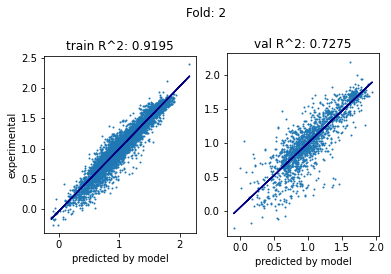

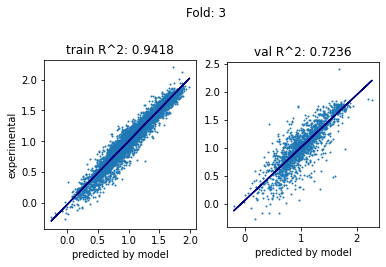

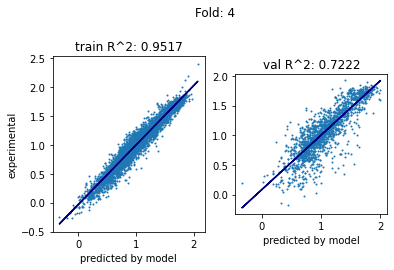

Train (using mean prediction) R^2= 0.9202190136303577
Test (using mean prediction) R^2= 0.7645791130973342


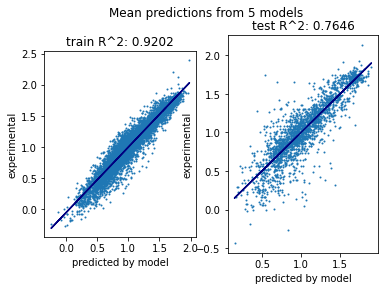

In [39]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
# print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
# print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");

## GroupKFold

Commented, because split to folds by topology gives worst results
